--- LTST: 3 ---
Slope: 0.0190, Intercept: -0.6163
P-value: 0.0406
--- LTST: 15 ---
Slope: 0.0454, Intercept: -1.3494
P-value: 0.0792


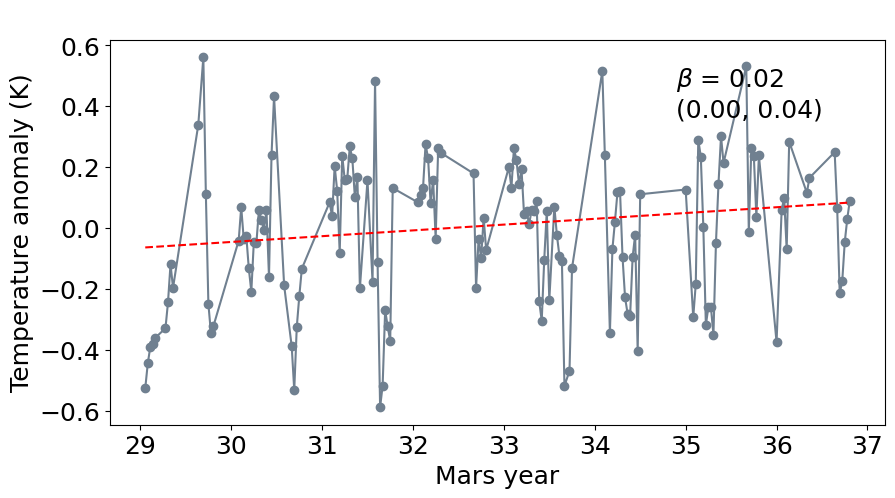

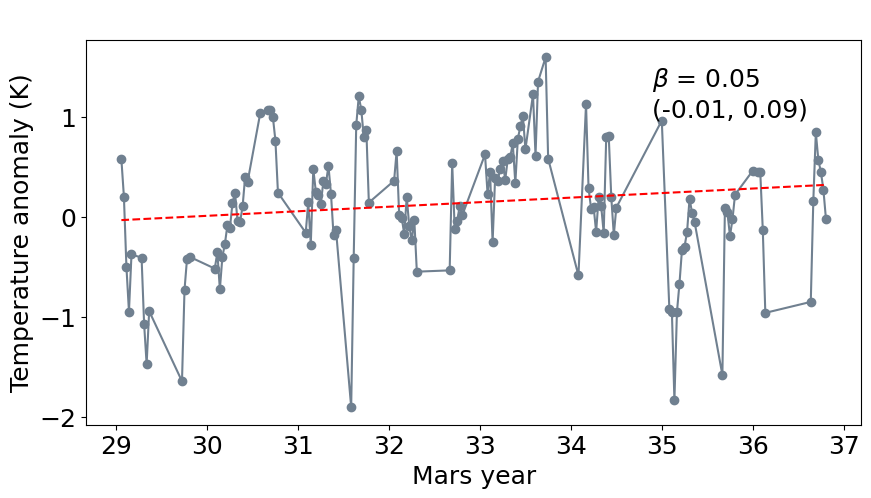

In [ ]:
import warnings
import numpy as np
import xarray as xr
from scipy.stats import theilslopes
import pymannkendall as mk
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# ==========================================
# CONFIGURATION
# ==========================================
CONFIG = {
    'input_file': '../data/MCS_tsurf_corrected.nc',
    'lat_range': slice(-60, 60),      # Lat slicing
    'my_range': slice(29, 36),        # Mars Year slicing
    'ltst_list': [3, 15],             # List of Local True Solar Times to process
    'masking': {
        'skip_my': 34,                # Year to mask specific event (e.g., GDS)
        'skip_ls_range': (180, 250),  # Ls range to mask in that year
        'min_count': 800,             # Min valid points per timestamp
        'std_threshold': 2            # Outlier threshold (n * std)
    },
    'plot': {
        'color': 'slategrey',
        'trend_color': 'red',
        'figsize': (10, 5)
    }
}

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def weight_mean(data):
    """Calculate area-weighted mean based on cosine of latitude."""
    weights = np.cos(np.deg2rad(data.Lat))
    weights.name = "weights"
    tsurf_weighted = data.weighted(weights)
    return tsurf_weighted.mean(("Lat", "Lon"))

def get_continuous_time(da: xr.DataArray) -> xr.DataArray:
    """
    Collapse Mars Year (MY) and Ls into a single continuous fractional coordinate.
    """
    # Create new continuous coordinate (MY + Ls/360)
    my_frac = da.coords["MY"] + da.coords["Ls"] / 360
    
    # Stack MY and Ls into one dimension
    da_stacked = da.stack(sample=("MY", "Ls"))
    
    # Assign new continuous coordinate and rename to MY for plotting compatibility
    da_stacked = da_stacked.assign_coords(sample=my_frac.values.flatten())
    da_stacked = da_stacked.rename({"sample": "MY"})
    
    return da_stacked

def process_ltst_data(ds, ltst, cfg):
    """Extracts, masks, and computes weighted mean anomaly for a specific LTST."""
    
    # 1. Selection
    da = ds['tsurf_correct'].loc[cfg['my_range'], :, ltst, cfg['lat_range']]

    # 2. Mask specific event (e.g., MY34 Storm)
    mask_event = (da.MY == cfg['masking']['skip_my']) & \
                 (da.Ls > cfg['masking']['skip_ls_range'][0]) & \
                 (da.Ls < cfg['masking']['skip_ls_range'][1])
    da = da.where(~mask_event)

    # 3. Anomaly Calculation
    da_clim = da.mean(dim='MY')
    da_anom = da - da_clim

    # 4. Convert to continuous time
    da_anom = get_continuous_time(da_anom)

    # 5. Density Masking (remove timesteps with too few data points)
    mask_density = da_anom.where(da_anom).count(dim=('Lat', 'Lon')) > cfg['masking']['min_count']
    da_anom = da_anom.where(mask_density)

    # 6. Weighted Mean
    da_weighted = weight_mean(da_anom)

    # 7. Outlier Masking (Standard Deviation)
    mask_outlier = np.abs(da_weighted) < cfg['masking']['std_threshold'] * da_weighted.std()
    da_weighted = da_weighted.where(mask_outlier)

    return da_weighted.dropna(dim='MY')

def calculate_stats(da_ts):
    """Calculates Theil-Sen slope and Mann-Kendall statistics."""
    y = da_ts.values
    x = da_ts.MY.values
    
    slope, intercept, low_slope, high_slope = theilslopes(y, x)
    p_value = mk.original_test(y).p
    
    return {
        'x': x, 'y': y,
        'slope': slope, 'intercept': intercept,
        'low_slope': low_slope, 'high_slope': high_slope,
        'p_value': p_value
    }

def plot_results(stats, ltst, cfg):
    """Plots the time series and trend line."""
    fig, ax = plt.subplots(figsize=cfg['plot']['figsize'])
    
    # Plot raw data
    ax.plot(stats['x'], stats['y'], c=cfg['plot']['color'])
    ax.scatter(stats['x'], stats['y'], c=cfg['plot']['color'])
    
    # Plot trend line
    x_fit = np.linspace(stats['x'][0], stats['x'][-1], len(stats['x']))
    y_fit = stats['slope'] * x_fit + stats['intercept']
    ax.plot(x_fit, y_fit, c=cfg['plot']['trend_color'], linestyle='--')

    # Formatting
    ax.tick_params(labelsize=18)
    ax.set_title(' ', loc='center', fontdict={'size': 20})
    ax.set_xlabel('Mars year', fontdict={'size': 18})
    ax.set_ylabel('Temperature anomaly (K)', fontdict={'size': 18})

    # Annotations
    ax.text(0.73, 0.88, r'$\beta$ ' + f'= {stats["slope"]:.2f}', 
            transform=ax.transAxes, fontsize=18)
    ax.text(0.73, 0.8, f'({stats["low_slope"]:.2f}, {stats["high_slope"]:.2f})', 
            transform=ax.transAxes, fontsize=18)
    
    # Print stats to console
    print(f"--- LTST: {ltst} ---")
    print(f"Slope: {stats['slope']:.4f}, Intercept: {stats['intercept']:.4f}")
    print(f"P-value: {stats['p_value']:.4f}")
    
    return fig, ax

# ==========================================
# MAIN EXECUTION
# ==========================================

ds_mcs = xr.open_dataset(CONFIG['input_file'])

# Loop through requested LTSTs
for ltst in CONFIG['ltst_list']:
    da_final = process_ltst_data(ds_mcs, ltst, CONFIG)
        
    stats = calculate_stats(da_final)
    plot_results(stats, ltst, CONFIG)
    
plt.show()
